# **C-calculate_Niño_index.ipynb**

Author: Zhixian Yang

Email: [yangzhx28@mail2.sysu.edu.cn](mailto:yangzhx28@mail2.sysu.edu.cn) or [yimu01439@gmail.com](mailto:yimu01439@gmail.com)

GitHub: [https://github.com/koar-create](https://github.com/koar-create)

Date created: July 27th, 2023

Last modified: July 27th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

# **<font color='red' size=5>0. download and import packages</font>**

In [1]:
import platform
if platform.system() == 'Linux':
    !pip install cdsapi --quiet
    !pip install imageio[ffmpeg] --quiet
    !pip install imageio[pyav] --quiet

In [2]:
# 1. downloaad
import cdsapi                         # download from Climate Data Store, ECMWF
import pooch, urllib.request          # download from any available URL
import s3fs, boto3, botocore          # download from S3 server, Amazon Web Service
from pythia_datasets import DATASETS  # download certain content from pythia

# 2. useful toolkits
from itertools import product
import os, sys, glob, time, tempfile

# 3. read and write
import h5py

# 4. data processing
from scipy import stats
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr

# 5. image processing
import imageio
import cartopy.io.shapereader as shapereader
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# **<font color='red' size=5>1. read data</font>**

### **<font face='Arial' size=4>Yang: Here we use the file `sst.mnmean.nc` under the folder `shared/Data/Projects/ENSO` with time resolution of 1-month.</font>**

In [3]:
# this nc file sst.mnmean.nc contains global monthly mean sea surface temperature (sst)
ds = xr.open_dataset(os.sep + os.path.join('home','jovyan', 'shared', 'Data', 'Projects', 'ENSO', 'sst.mnmean.nc'))
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2034, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-06-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-07-03

# **<font color='red' size=5>2. calculate and plot Niño Index</font>**

## **<font size=5>2.1. plot Niño Index</font>**

In [4]:
# specify the start time and end time
start_time, end_time = '1979-01', '2023-05'
# specify the extent of Nino 3.4
nino_region = [190.0, 240.0, -5.0, 5.0]
# select sst from the time period and region we're interested in
sst_nino = ds.sst.sel(time=slice(start_time, end_time), 
                      lat=slice(nino_region[-1], nino_region[-2]), 
                      lon=slice(nino_region[ 0], nino_region[ 1]))

# calculate the sst climatology over Nino 3.4 region, choose 1981-2010 as the time period
climatology = ds.sst.sel(time=slice('1981', '2010')).mean('time')

# obtain the sst anomalies over Nino 3.4 region. 
sst_anom_nino = sst_nino - climatology

# perform spatial average operation, get a time series of sst anomalies over Nino 3.4 region
sst_anom_series_nino = sst_anom_nino.mean(dim=['lon', 'lat'])

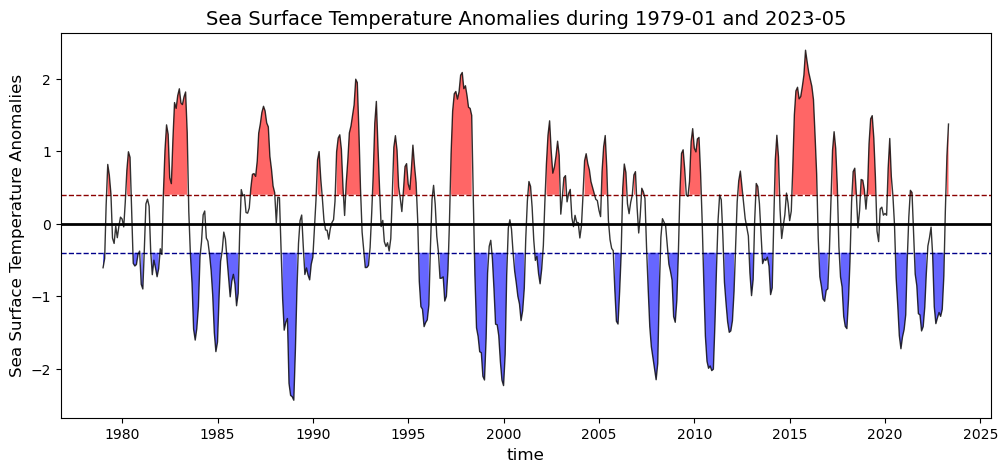

In [5]:
# We set the threshold as 0.4, which is defined by Japan Meteorological Administration (JMA). 
# When sst anomaly over Nino 3.4 region is lager than or equal to 0.4 for six consecutive months, 
# we consider El Nino event to have occurred. Similarily, When sst anomaly over Nino 3.4 region is
# less than or equal to -0.4, we consider La Nina event to have occurred. 
threshold = 0.4

fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
ax.axhline( 0.0      , color='k'       , alpha=1, linewidth=2, linestyle='solid')
ax.axhline( threshold, color='darkred' , alpha=1, linewidth=1, linestyle='dashed')
ax.axhline(-threshold, color='darkblue', alpha=1, linewidth=1, linestyle='dashed')
ax.plot(        sst_anom_series_nino.time, sst_anom_series_nino,  linewidth=1, linestyle='solid', color='k', alpha=0.8)
ax.fill_between(sst_anom_series_nino.time, sst_anom_series_nino,  threshold, where=sst_anom_series_nino >  threshold, facecolor='r', alpha=0.6)
ax.fill_between(sst_anom_series_nino.time, sst_anom_series_nino, -threshold, where=sst_anom_series_nino < -threshold, facecolor='b', alpha=0.6)
ax.set_xlabel('time', size=12), ax.set_ylabel('Sea Surface Temperature Anomalies', size=12), ax.set_title(f"Sea Surface Temperature Anomalies during {start_time} and {end_time}", size=14)

plt.savefig(os.path.join('Figure', 'Niño_Index.png'), dpi=100)